In [1]:
import nest
import nest.raster_plot
import numpy as np
from helper import generate_input
import matplotlib.pyplot as plt

In this example, we will compare the network dynamics in the noise- and input-driven regimes. For that purpose, we first drive the network with constant Poissonian input for a period of 1s, followed by patterned stimulation with an inhomogeneous Poisson generator for an additional 1s. 

# Global settings

In [2]:
seed = 1
np.random.seed(seed)

In [3]:
dt = 0.1  # simulation resolution
sim_time = 1000. # simulation time [ms] (for each epoch)

num_threads = 8

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'grng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

---
# Balanced Random Network

For this example, we will use a standard Brunel balanced random network (see NEST tutorials). However, you are encouraged to explore different neuron and synapse models.

In [4]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

In [5]:
# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

In [6]:
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

### Create and connect populations

In [7]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create excitatory connections
# synapse specification
syn_exc = {'delay': d, 'weight': w}
# connection specification
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
# connect stuff
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# create inhibitory connections
# synapse specification
syn_inh = {'delay': d, 'weight': - g * w}
# connection specification
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
# connect stuff
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

### Create and connect external inputs
We are going to drive the circuit with noise for an initial period, followed by a patterned stimulus signal.

In [8]:
# external input parameters (background noise)
nu_th = V_th / (w * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 2.0 * nu_th        # set external rate above threshold
p_rate = 1e3 * nu_ex       # external rate (spikes/s)

In [9]:
# external input (stimulus)
step_duration = 50.    # [ms]
scale = p_rate / 2.    # scale input amplitude (max. rate)

sig, times, inp_times, inp_amplitudes = generate_input(seed=seed, num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)
inp_times += sim_time  # stimulus starts after the noise phase

Text(0.5, 1.0, '$u(t)$')

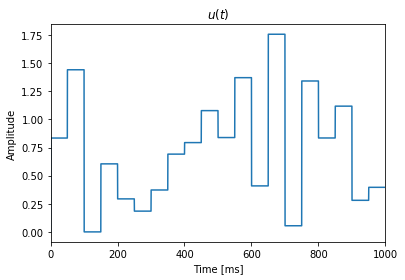

In [10]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [11]:
# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})

In [12]:
# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

### Create and connect recording devices
Since we are going to compare the population responses to stimulus versus noise, the simplest way is to record them separately. 

In [13]:
spikes_E_noise = nest.Create('spike_detector')
nest.SetStatus(spikes_E_noise, {'stop': sim_time})
spikes_I_noise = nest.Create('spike_detector')
nest.SetStatus(spikes_I_noise, {'stop': sim_time})
spikes_E_stim  = nest.Create('spike_detector')
nest.SetStatus(spikes_E_stim, {'start': sim_time})
spikes_I_stim  = nest.Create('spike_detector')
nest.SetStatus(spikes_I_stim, {'start': sim_time})

In [14]:
# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_noise)
nest.Connect(neurons_i, spikes_I_stim)

## Simulate and analyse

In [15]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 84.7985 Hz (E: 84.697 Hz, I: 84.9 Hz)


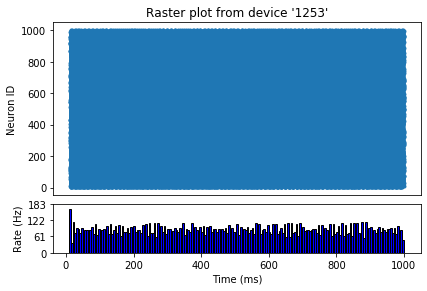

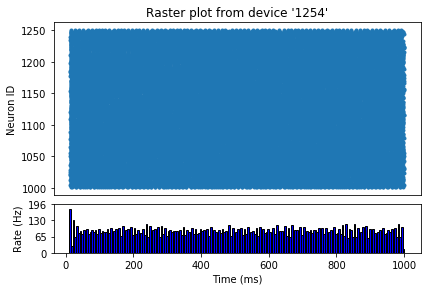

In [16]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
nest.raster_plot.from_device(spikes_I_noise, hist=True)

In [17]:
# simulate (stimulus-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 12.306000000000001 Hz (E: 12.192 Hz, I: 12.42 Hz)


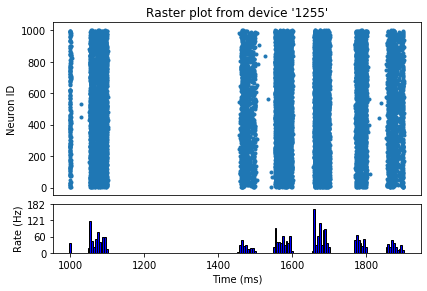

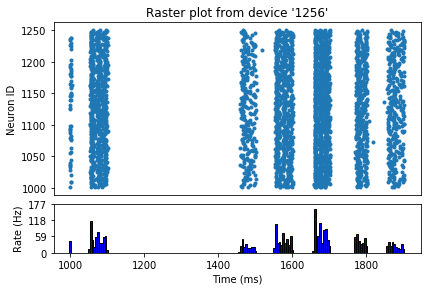

In [18]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
nest.raster_plot.from_device(spikes_I_stim, hist=True)

To explore:

* Characterize the population activity statistics in the two regimes, evaluating the distribution of rates, regularity ($CV_{ISI}$) and synchrony (pairwise correlation coefficient) 
* Change the stimulation parameters to reach a *healthier* dynamic regime in the input-driven condition
* Test different neuron and synapse models